In [1]:
import torch
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from src.preprocessing import Data
from src.models import TextClassifierTransformer
from transformers import BertForSequenceClassification
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report

In [3]:
batch_size=16
plt.rcParams["figure.figsize"] = (10, 10)  # Ajuster la taille globale
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu" )
data = Data(bert_token = True, train_file = "data/train_dataset.csv", test_file = "data/test_dataset.csv", val_file = "data/validation_dataset.csv", max_length=64)
train_dataloader, validation_dataloader, test_dataloader = data.load_data(batch_size)

In [4]:
# TRANSFORMER FR
# Parameters 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu" )
print(device)
dmodel: int=64
n_head: int=1
num_layers: int=1
vocab_size: int= len(data.tokenizer.get_vocab())

if data.output_dim is not None:
    output_dim: int= data.output_dim 
else:
    raise "Output dimension is unknown"

dim_feedforward: int=2 * dmodel
dropout: float=0.5
max_len: int=vocab_size

mps


In [5]:
model_TRANS = TextClassifierTransformer(vocab_size=vocab_size, output_dim=output_dim, num_layers=num_layers, n_head=n_head, d_model=dmodel, dim_feedforward=dim_feedforward, dropout=dropout, max_len=max_len)
model_TRANS.load_state_dict(torch.load("models/transformers_model_fn.pth"))

/opt/homebrew/Caskroom/mambaforge/base/envs/txt_ml_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [6]:
# BERT
model_BERT = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=output_dim)
model_BERT.load_state_dict(torch.load("models/bert_model.pth", map_location=device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [7]:
# BERT
model_BERT_LORA = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=output_dim)

lora_config = LoraConfig(
    r=8, # Taille des matrices de basse-rang
    lora_alpha=16, # Facteur de mise à l’échelle
    lora_dropout=0.1, # Dropout pour éviter le sur-apprentissage
    bias="none",
    task_type="SEQ_CLS" # Pour classification de texte (Sequence Classification)
)
model_BERT_LORA = get_peft_model(model_BERT_LORA, lora_config)
model_BERT_LORA.print_trainable_parameters()  # Vérifier que seuls les paramètres LoRA sont entraînables
model_BERT_LORA.load_state_dict(torch.load("models/lora_bert_model.pth"))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 299,526 || all params: 109,786,380 || trainable%: 0.2728


<All keys matched successfully>

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
# Tokenisation des textes
texts = [
    "I feel so alone and lost...",
    "This is the best day of my life!",
    "I love spending time with you.",
    "I'm so angry at what he did to me!",
    "I can't stop shaking, I'm so scared.",
    "Wow! I didn't see that coming!",
    "this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert"
]

inputs = data.tokenizer(texts, padding="max_length", truncation=True, max_length=128)
src_inp = torch.tensor(inputs['input_ids'])
src_mask = torch.tensor(inputs['attention_mask'], dtype=torch.bool)
src_inp = src_inp.to(device)
src_mask = src_mask.to(device)

"""
with torch.no_grad():
    model_BERT.eval()
    outputs = model_BERT(src_inp, src_mask)
    outputs_prob  = torch.nn.functional.softmax(outputs.logits, dim=1)
    predictions = torch.argmax(outputs_prob, dim=1)
    print("Predictions BERT")
    print(predictions)
"""

with torch.no_grad():
    device_lora = torch.device("cpu")
    src_inp = src_inp.to(device_lora)
    src_mask = src_mask.to(device_lora)
    model_BERT_LORA.eval()
    outputs = model_BERT_LORA(src_inp, src_mask)
    outputs_prob  = torch.nn.functional.softmax(outputs.logits, dim=1)
    predictions = torch.argmax(outputs_prob, dim=1)
    print("Predictions BERT LORA")
    print(predictions)
    
with torch.no_grad():
    model_TRANS.eval()
    outputs = model_TRANS(src_inp, src_mask)
    outputs_prob  = torch.nn.functional.softmax(outputs, dim=1)
    predictions = torch.argmax(outputs_prob, dim=1)
    print("Predictions TFS")
    print(predictions)

Predictions BERT LORA
tensor([0, 1, 2, 3, 4, 1, 1])
Predictions TFS
tensor([0, 1, 1, 3, 4, 1, 1])


In [10]:
# BERT LOSS AND ACCURACY ON TEST DATASET
losstot = 0
correct = 0
target_bert = []
predicted_bert = []

with torch.no_grad():  # Pas de calcul des gradients
    model_BERT.eval()  # Mode évaluation
    model_BERT.to(device)
    for source, target, mask in tqdm(test_dataloader):
        target = target.to(device)
        source = source.to(device)
        mask = mask.to(device).bool()
        # Passage avant
        outputs = model_BERT(source, mask)
        # Calcul de la perte
        loss = criterion(outputs.logits, target)
        # Calcul des prédictions
        predicted = torch.argmax(outputs.logits, dim=1)
        correct += (predicted == target).sum().item()
        losstot += loss.item()  
        predicted_bert.extend(predicted.detach().cpu().numpy().reshape(-1))
        target_bert.extend(target.detach().cpu().numpy().reshape(-1))

# Calcul de l'accuracy
accuracy = 100 * correct / len(test_dataloader.dataset)
print(f'BERT Loss: {losstot / len(test_dataloader)}')  # Afficher la perte moyenne
print(f'BERT Accuracy: {accuracy}%')  # Afficher l'accuracy en pourcentage

100%|██████████| 125/125 [00:23<00:00,  5.25it/s]

BERT Loss: 0.15989778290316461
BERT Accuracy: 92.65%


In [11]:
# BERT LORA LOSS AND ACCURACY ON TEST DATASET
losstot = 0
correct = 0
target_bert_lora = []
predicted_bert_lora = []

with torch.no_grad():  # Pas de calcul des gradients
    model_BERT_LORA.eval()  # Mode évaluation
    model_BERT_LORA.to(device_lora)
    for source, target, mask in tqdm(test_dataloader):
        target = target.to(device_lora)
        source = source.to(device_lora)
        mask = mask.to(device_lora).bool()
        # Passage avant
        outputs = model_BERT_LORA(source, mask)
        # Calcul de la perte
        loss = criterion(outputs.logits, target)
        # Calcul des prédictions
        predicted = torch.argmax(outputs.logits, dim=1)
        correct += (predicted == target).sum().item()
        losstot += loss.item()  
        target_bert_lora.extend(predicted.detach().cpu().numpy().reshape(-1))
        predicted_bert_lora.extend(target.detach().cpu().numpy().reshape(-1))

# Calcul de la précision
accuracy = 100 * correct / len(test_dataloader.dataset)
print(f'BERT LORA Loss: {losstot / len(test_dataloader)}')  # Afficher la perte moyenne
print(f'BERT LORA Accuracy: {accuracy}%')  # Afficher la précision en pourcentage

100%|██████████| 125/125 [00:47<00:00,  2.61it/s]

BERT LORA Loss: 0.26589315018057824
BERT LORA Accuracy: 90.85%


In [12]:
# TRANSFOrMER FS LOSS AND ACCURACY ON TEST DATASET
losstot = 0
correct = 0
target_trans = []
predicted_trans = []

with torch.no_grad():  # Pas de calcul des gradients
    model_TRANS.eval()  # Mode évaluation
    model_TRANS.to(device)
    for source, target, mask in tqdm(test_dataloader):
        target = target.to(device)
        source = source.to(device)
        mask = mask.to(device).bool()
        # Passage avant
        outputs = model_TRANS(source, mask)
        # Calcul de la perte
        loss = criterion(outputs, target)
        # Calcul des prédictions
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == target).sum().item()
        losstot += loss.item()  
        predicted_trans.extend(predicted.detach().cpu().numpy().reshape(-1))
        target_trans.extend(target.detach().cpu().numpy().reshape(-1))

# Calcul de la précision
accuracy = 100 * correct / len(test_dataloader.dataset)
print(f'TFS Loss: {losstot / len(test_dataloader)}')  # Afficher la perte moyenne
print(f'TFS Accuracy: {accuracy}%')  # Afficher la précision en pourcentage

100%|██████████| 125/125 [00:02<00:00, 47.56it/s]

TFS Loss: 0.2899790389984846
TFS Accuracy: 89.2%


In [13]:
# BERT
acc_score = accuracy_score(target_bert, predicted_bert)
precision = precision_score(target_bert, predicted_bert, average="weighted")
recall = recall_score(target_bert, predicted_bert, average="weighted")
f1 = f1_score(target_bert, predicted_bert, average="weighted")
print(f'Accuracy: {acc_score}')
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")

Accuracy: 0.9265
Précision : 0.93
Rappel : 0.93
F1-score : 0.93


In [14]:
# BERT LORA
acc_score = accuracy_score(target_bert_lora, predicted_bert_lora)
precision = precision_score(target_bert_lora, predicted_bert_lora, average="weighted")
recall = recall_score(target_bert_lora, predicted_bert_lora, average="weighted")
f1 = f1_score(target_bert_lora, predicted_bert_lora, average="weighted")
print(f'Accuracy: {acc_score}')
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")

Accuracy: 0.9085
Précision : 0.91
Rappel : 0.91
F1-score : 0.91


In [15]:
# TFS
acc_score = accuracy_score(target_trans, predicted_trans)
precision = precision_score(target_trans, predicted_trans, average="weighted")
recall = recall_score(target_trans, predicted_trans, average="weighted")
f1 = f1_score(target_trans, predicted_trans, average="weighted")
print(f'TFS Accuracy: {acc_score}')
print(f"TFS Précision : {precision:.2f}")
print(f"TFS Rappel : {recall:.2f}")
print(f"TFS F1-score : {f1:.2f}")

TFS Accuracy: 0.892
TFS Précision : 0.90
TFS Rappel : 0.89
TFS F1-score : 0.89


In [16]:
# BERT:
print(classification_report(target_bert, predicted_bert, digits=2))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       581
           1       0.94      0.96      0.95       695
           2       0.85      0.81      0.83       159
           3       0.94      0.89      0.91       275
           4       0.86      0.92      0.89       224
           5       0.84      0.64      0.72        66

    accuracy                           0.93      2000
   macro avg       0.90      0.86      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [17]:
# BERT LORA:
print(classification_report(target_bert_lora, predicted_bert_lora, digits=2))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       574
           1       0.95      0.93      0.94       706
           2       0.77      0.80      0.78       152
           3       0.92      0.90      0.91       281
           4       0.88      0.89      0.88       220
           5       0.77      0.76      0.77        67

    accuracy                           0.91      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.91      0.91      0.91      2000



In [18]:
# TFS 
print(classification_report(target_trans, predicted_trans, digits=2))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       581
           1       0.94      0.89      0.92       695
           2       0.69      0.90      0.78       159
           3       0.94      0.84      0.88       275
           4       0.83      0.92      0.88       224
           5       0.72      0.62      0.67        66

    accuracy                           0.89      2000
   macro avg       0.84      0.85      0.84      2000
weighted avg       0.90      0.89      0.89      2000



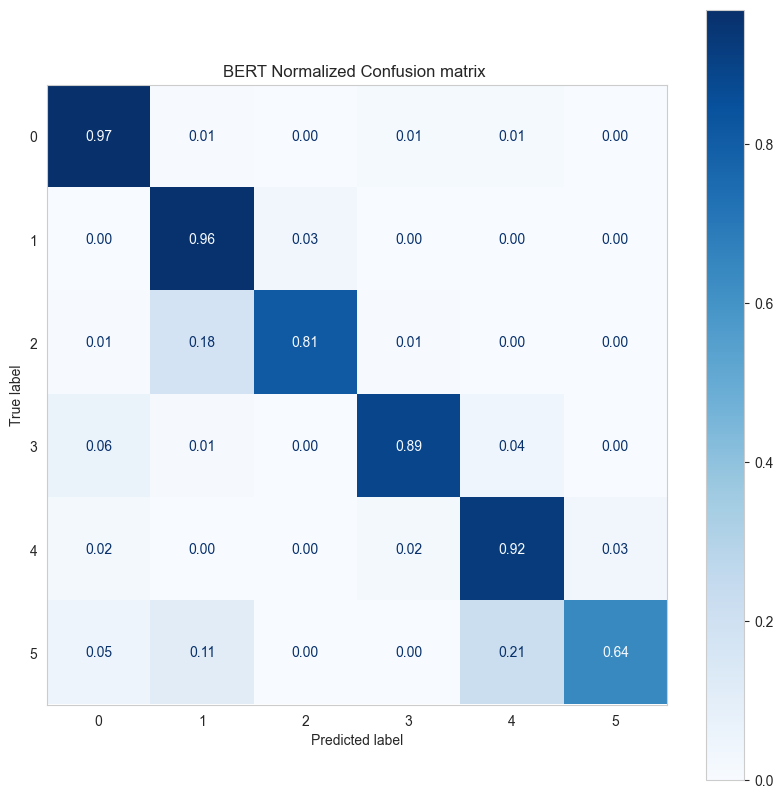

In [20]:
# BERT:
clf_classes = [i for i in range(output_dim)]
conf_mat_norm = confusion_matrix(target_bert, predicted_bert, normalize='true', labels=clf_classes)
# Afficher la matrice avec matplotlib
disp_norm = ConfusionMatrixDisplay(confusion_matrix=conf_mat_norm, display_labels=clf_classes)
disp_norm.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("BERT Normalized Confusion matrix ")
plt.grid(False)
plt.show()

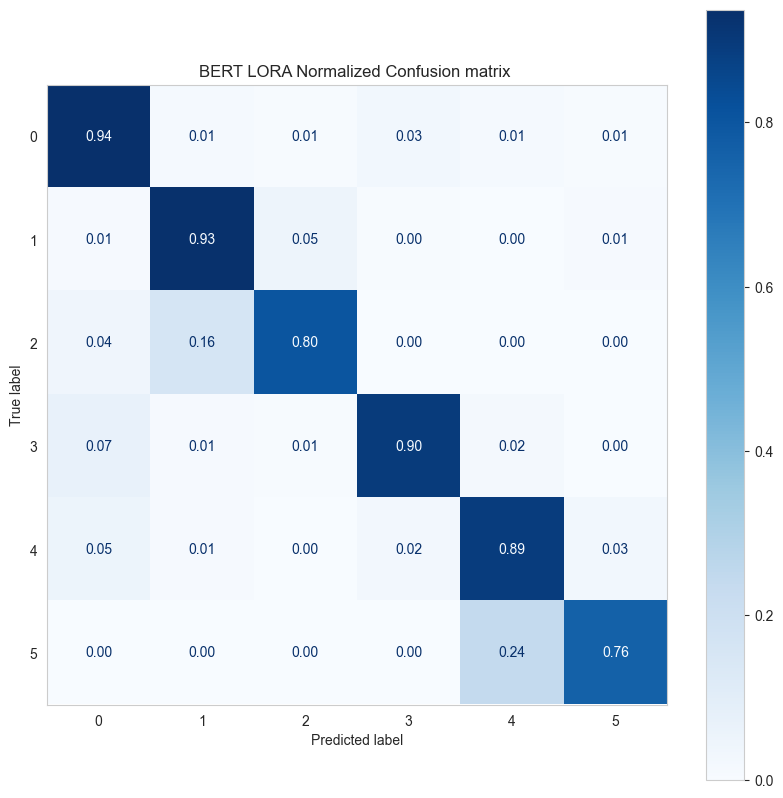

In [21]:
# BERT LORA:
clf_classes = [i for i in range(output_dim)]
conf_mat_norm = confusion_matrix(target_bert_lora, predicted_bert_lora, normalize='true', labels=clf_classes)
# Afficher la matrice avec matplotlib
disp_norm = ConfusionMatrixDisplay(confusion_matrix=conf_mat_norm, display_labels=clf_classes)
disp_norm.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("BERT LORA Normalized Confusion matrix ")
plt.grid(False)
plt.show()

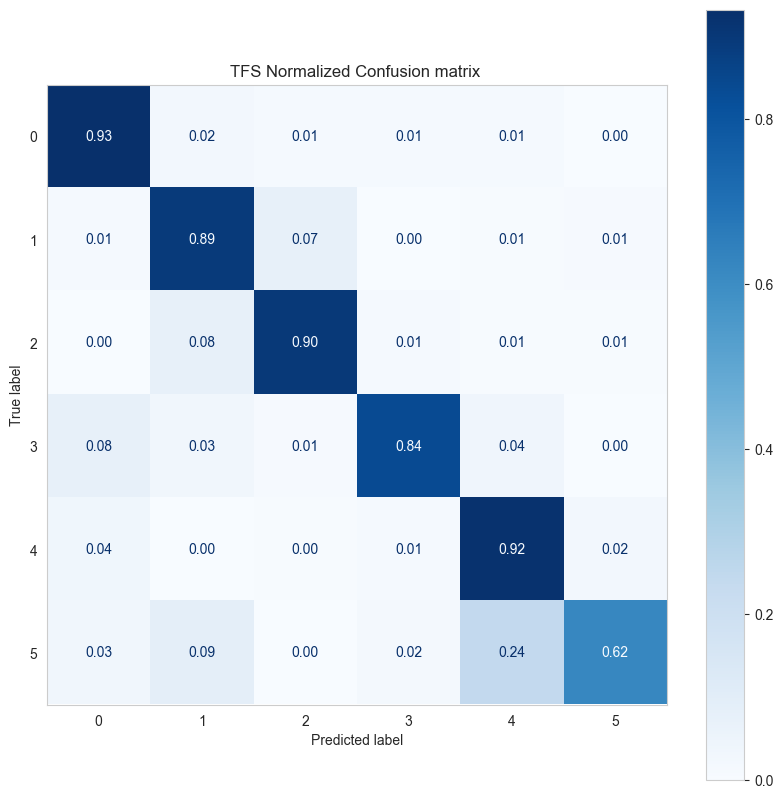

In [22]:
# TFS:
conf_mat_norm = confusion_matrix(target_trans, predicted_trans, normalize='true', labels=clf_classes)
# Afficher la matrice avec matplotlib
disp_norm = ConfusionMatrixDisplay(confusion_matrix=conf_mat_norm, display_labels=clf_classes)
disp_norm.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("TFS Normalized Confusion matrix ")
plt.grid(False)
plt.show()

In [23]:
# Supposons que ton modèle s'appelle `model`
total_params = sum(p.numel() for p in model_TRANS.parameters())
trainable_params = sum(p.numel() for p in model_TRANS.parameters() if p.requires_grad)
print(f"TFS Total parameters: {total_params}")
print(f"TFS Trainable parameters: {trainable_params}")

TFS Total parameters: 1987270
TFS Trainable parameters: 1987270


In [24]:
# Supposons que ton modèle s'appelle `model`
total_params = sum(p.numel() for p in model_BERT.parameters())
trainable_params = sum(p.numel() for p in model_BERT.parameters() if p.requires_grad)
print(f"BERT Total parameters: {total_params}")
print(f"BERT Trainable parameters: {trainable_params}")

BERT Total parameters: 109486854
BERT Trainable parameters: 109486854


In [25]:
# Supposons que ton modèle s'appelle `model`
total_params = sum(p.numel() for p in model_BERT_LORA.parameters())
trainable_params = sum(p.numel() for p in model_BERT_LORA.parameters() if p.requires_grad)

print(f"BERT LORA Total parameters: {total_params}")
print(f"BERT LORA Trainable parameters: {trainable_params}")

BERT LORA Total parameters: 109786380
BERT LORA Trainable parameters: 299526
